In [1]:
source('../../source/basic.r')

source('../validataion.r')


Warning message:
“no function found corresponding to methods exports from ‘BSgenome’ for: ‘releaseName’”


In [3]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(Signac)
    library(Seurat)
    library(GenomeInfoDb)
    library(EnsDb.Hsapiens.v86 )# hg38
   # library(EnsDb.Hsapiens.v75) #hg19
    library(ggplot2)
    library(patchwork)
    library(data.table)
    library(Matrix)
    set.seed(1234)
})

# peak data

## read data

In [4]:
counts <- readMM("data/d89P_fetal_filtered_peak_bc_matrix//matrix.mtx") 


In [5]:
counts%>%dim

[1] 297507  12107

In [6]:
colnames(counts) <- fread('data/d89P_fetal_filtered_peak_bc_matrix/barcodes.tsv',header = FALSE)%>%
                    pull(V1)

rownames(counts) <- fread('data/d89P_fetal_filtered_peak_bc_matrix/peaks.bed')%>%mutate(name=paste0(V1,':',V2,'-',V3))%>%pull(name)

In [7]:
counts[1:3,1:3]

3 x 3 sparse Matrix of class "dgTMatrix"
                   AAACGAAAGACCATAA-1 AAACGAAAGAGAGGTA-1 AAACGAAAGCATTCCA-1
chr1:181270-181868                  .                  .                  .
chr1:190662-191773                  .                  .                  .
chr1:267767-268236                  .                  .                  .

In [9]:
metadata <- fread('data/raw/GSM5585612_d89P_fetal_metadata.csv.gz')

In [10]:
metadata%>%dim

[1] 9526   34

### subset using metadata

In [13]:
counts.sub <- counts[,intersect(metadata$V1,colnames(counts))]

In [14]:
counts.sub[1:3,1:3]

3 x 3 sparse Matrix of class "dgTMatrix"
                   TAGCATGAGAGAGTAG-1 TGTTAGGGTTGGAGGT-1 GCAACCGTCTTGTACT-1
chr1:181270-181868                  2                  2                  2
chr1:190662-191773                  .                  .                  .
chr1:267767-268236                  .                  .                  .

In [15]:
metadata.sub <- metadata%>%dplyr::filter(V1%in%intersect(metadata$V1,colnames(counts)))%>%column_to_rownames('V1')

## build seurat object

In [16]:
chrom_assay <- CreateChromatinAssay(
  counts = counts.sub,
  sep = c(":", "-"),
  genome = 'hg38',
  fragments = './data/fragments/GSM5585612_d89P_fetal_fragments.tsv.gz',
  min.cells = 0,
  min.features = 0
)


Computing hash



In [17]:
seurat.object.all <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata.sub
)

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from peaks to peaks_"


In [18]:
seurat.object.all

An object of class Seurat 
297507 features across 9526 samples within 1 assay 
Active assay: peaks (297507 features, 0 variable features)

In [19]:
seurat.object <- subset(seurat.object.all, cells = rownames(metadata.sub))

In [20]:
seurat.object

An object of class Seurat 
297507 features across 9526 samples within 1 assay 
Active assay: peaks (297507 features, 0 variable features)

In [21]:
seurat.object <- RunTFIDF(seurat.object)
seurat.object <- FindTopFeatures(seurat.object, min.cutoff = 'q0')
seurat.object <- RunSVD(seurat.object)

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings



In [22]:
psize(4,4)

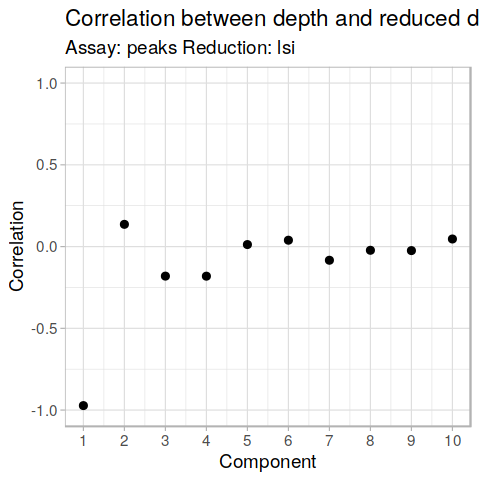

In [23]:
DepthCor(seurat.object)

In [24]:
suppressMessages({
    
    seurat.object <- RunUMAP(object = seurat.object, reduction = 'lsi', dims = 2:30)
    seurat.object <- FindNeighbors(object = seurat.object, reduction = 'lsi', dims = 2:30)
    seurat.object <- FindClusters(object = seurat.object, verbose = FALSE, algorithm = 3)
    # p.umpa.cluster = DimPlot(object = seurat.object, label = TRUE) + NoLegend()
    
})


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"


In [25]:
p.umpa.cluster = DimPlot(object = seurat.object, label = TRUE) + NoLegend()

In [26]:
psize()

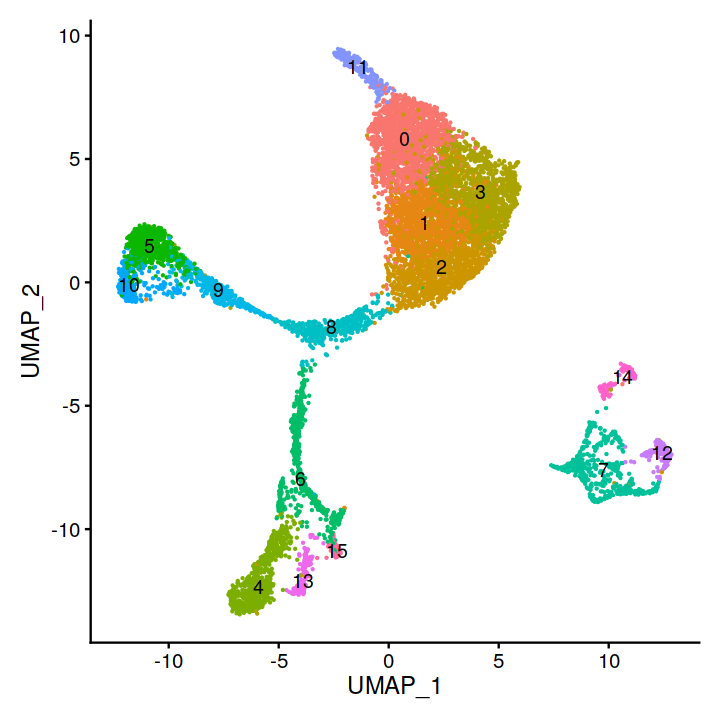

In [27]:
p.umpa.cluster

In [28]:
p.umpa.label = DimPlot(object = seurat.object,group.by='type',label = TRUE) + NoLegend()

In [29]:
psize(6,6)

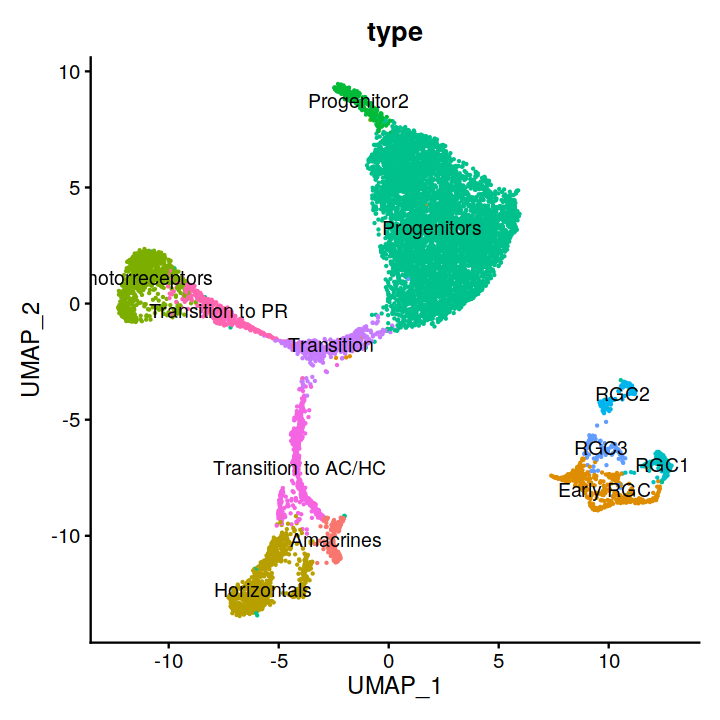

In [30]:
p.umpa.label

# cPeaks

## read data

In [32]:
counts <- readMM("data/d89P_fetal_filtered_peak_bc_matrix//matrix.cpeak.mtx") 


In [33]:
counts%>%dim

[1] 1568814   12107

In [34]:
colnames(counts) <- fread('data/d89P_fetal_filtered_peak_bc_matrix/barcodes.tsv',header = FALSE)%>%
                    pull(V1)

rownames(counts) <- fread('data/cpeak.bed')%>%mutate(name=paste0(V1,':',V2,'-',V3))%>%pull(name)

In [35]:
counts[1:3,1:3]

3 x 3 sparse Matrix of class "dgTMatrix"
                 AAACGAAAGACCATAA-1 AAACGAAAGAGAGGTA-1 AAACGAAAGCATTCCA-1
chr1:9919-10727                   .                  .                  .
chr1:11043-11422                  .                  .                  .
chr1:13249-13832                  .                  .                  .

### subset using metadata

In [36]:
counts.sub <- counts[,intersect(metadata$V1,colnames(counts))]

In [37]:
counts.sub[1:3,1:3]

3 x 3 sparse Matrix of class "dgTMatrix"
                 TAGCATGAGAGAGTAG-1 TGTTAGGGTTGGAGGT-1 GCAACCGTCTTGTACT-1
chr1:9919-10727                   .                  .                  .
chr1:11043-11422                  .                  .                  .
chr1:13249-13832                  .                  .                  .

In [38]:
metadata.sub <- metadata%>%dplyr::filter(V1%in%intersect(metadata$V1,colnames(counts)))%>%column_to_rownames('V1')

## build seurat object

In [39]:
chrom_assay <- CreateChromatinAssay(
  counts = counts.sub,
  sep = c(":", "-"),
  genome = 'hg38',
  fragments = './data/fragments/GSM5585612_d89P_fetal_fragments.tsv.gz',
  min.cells = 10,
  min.features = 0
)


Warning message in CreateChromatinAssay(counts = counts.sub, sep = c(":", "-"), :
"Overlapping ranges supplied. Ranges should be non-overlapping."
Computing hash



In [40]:
seurat.object.cpeak.all <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata.sub
)

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from peaks to peaks_"


In [41]:
seurat.object.cpeak.all

An object of class Seurat 
281162 features across 9526 samples within 1 assay 
Active assay: peaks (281162 features, 0 variable features)

In [42]:
seurat.object.cpeak <- subset(seurat.object.cpeak.all, cells = rownames(metadata.sub))

In [43]:
seurat.object.cpeak

An object of class Seurat 
281162 features across 9526 samples within 1 assay 
Active assay: peaks (281162 features, 0 variable features)

In [44]:
seurat.object.cpeak <- RunTFIDF(seurat.object.cpeak)
seurat.object.cpeak <- FindTopFeatures(seurat.object.cpeak, min.cutoff = 'q0')


Performing TF-IDF normalization



In [45]:
seurat.object.cpeak <- RunSVD(seurat.object.cpeak)

Running SVD

Scaling cell embeddings



In [46]:
psize(4,4)

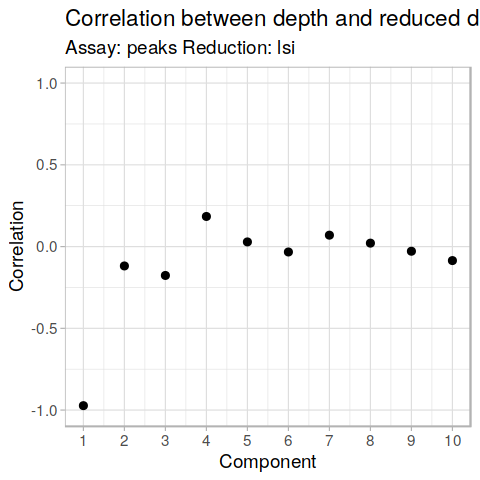

In [47]:
DepthCor(seurat.object.cpeak)

In [48]:
suppressMessages({
    
    seurat.object.cpeak <- RunUMAP(object = seurat.object.cpeak, reduction = 'lsi', dims = 2:30)
    seurat.object.cpeak <- FindNeighbors(object = seurat.object.cpeak, reduction = 'lsi', dims = 2:30)
    seurat.object.cpeak <- FindClusters(object = seurat.object.cpeak, verbose = FALSE, algorithm = 3)
    # p.umpa.cluster = DimPlot(object = seurat.object, label = TRUE) + NoLegend()
    
})


In [49]:
p.umpa.cluster.cpeak = DimPlot(object = seurat.object.cpeak, label = TRUE) + NoLegend()

In [50]:
psize()

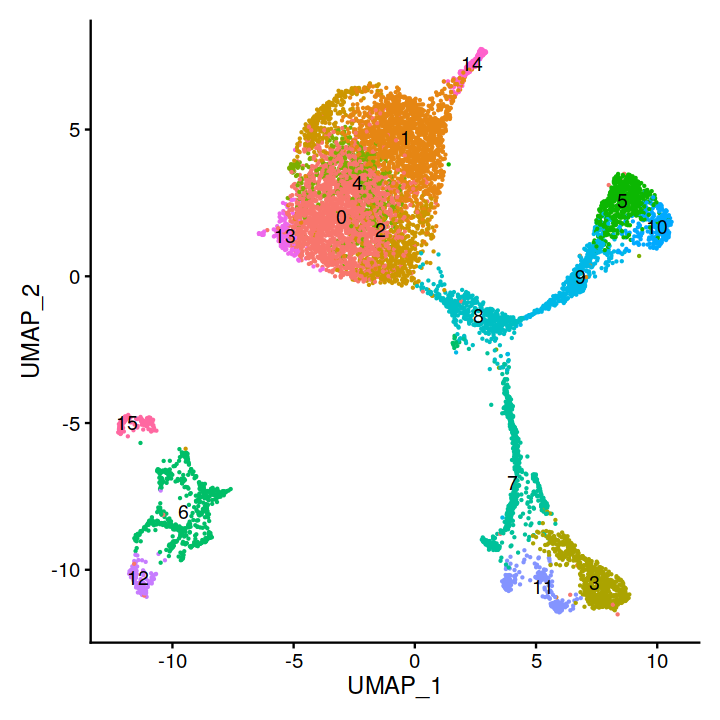

In [51]:
p.umpa.cluster.cpeak

In [52]:
p.umpa.label.cpeak = DimPlot(object = seurat.object.cpeak,group.by='type',label = TRUE) + NoLegend()

In [53]:
psize(6,6)

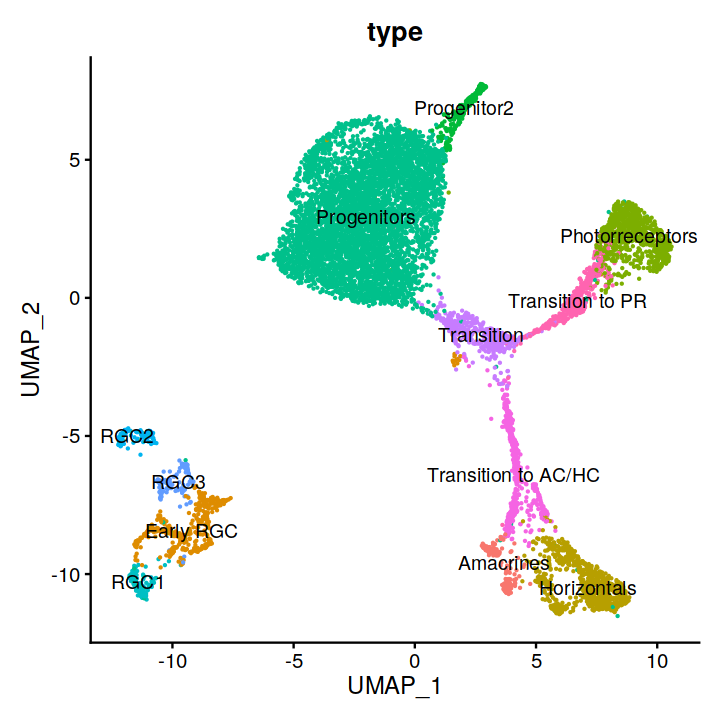

In [54]:
p.umpa.label.cpeak

# save

In [56]:
seurat.objct.list <- list(peaks=seurat.object, cpeaks=seurat.object.cpeak)

In [57]:
qsave(seurat.objct.list,'rds/fw13p.seurat.objct.list.qs')

In [58]:
psize(6,6)

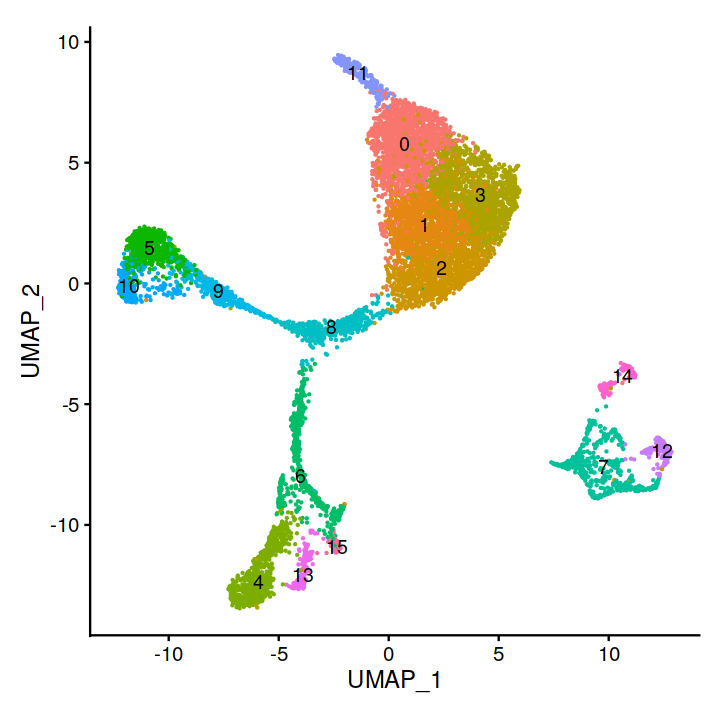

In [59]:
p.umpa.cluster+theme(aspect.ratio = 1) 

In [60]:
ggsave(paste0('plot/fw13p.peak.umpa.cluster.pdf'),height = 6,width = 6)

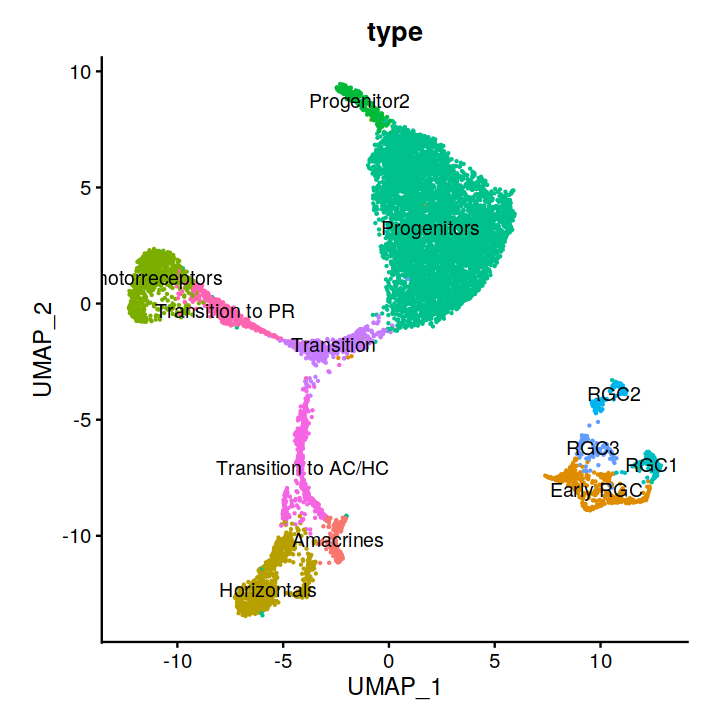

In [61]:
p.umpa.label+theme(aspect.ratio = 1) 

In [62]:
ggsave(paste0('plot/fw13p.peak.umpa.label.pdf'),height = 6,width = 6)

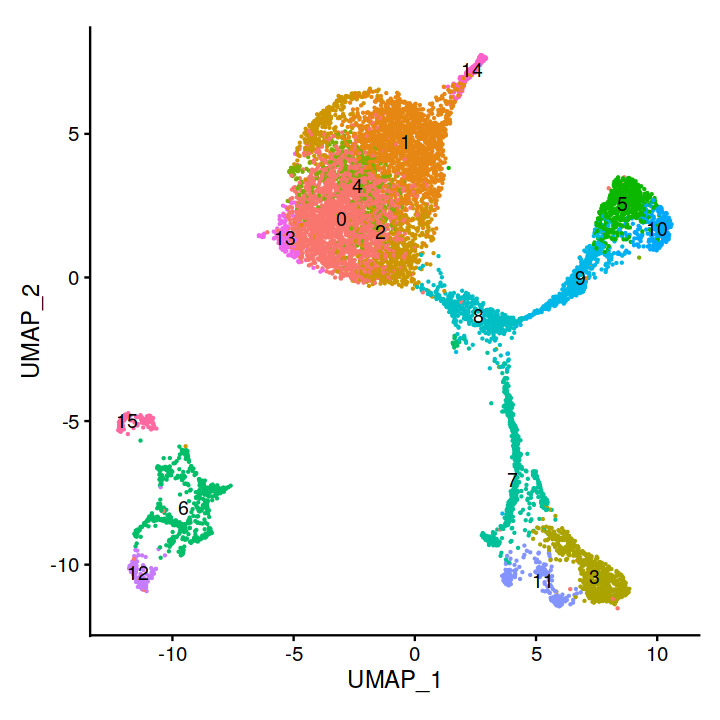

In [63]:
p.umpa.cluster.cpeak+theme(aspect.ratio = 1) 

In [64]:
ggsave(paste0('plot/fw13p.cpeak.umpa.cluster.pdf'),height = 6,width = 6)

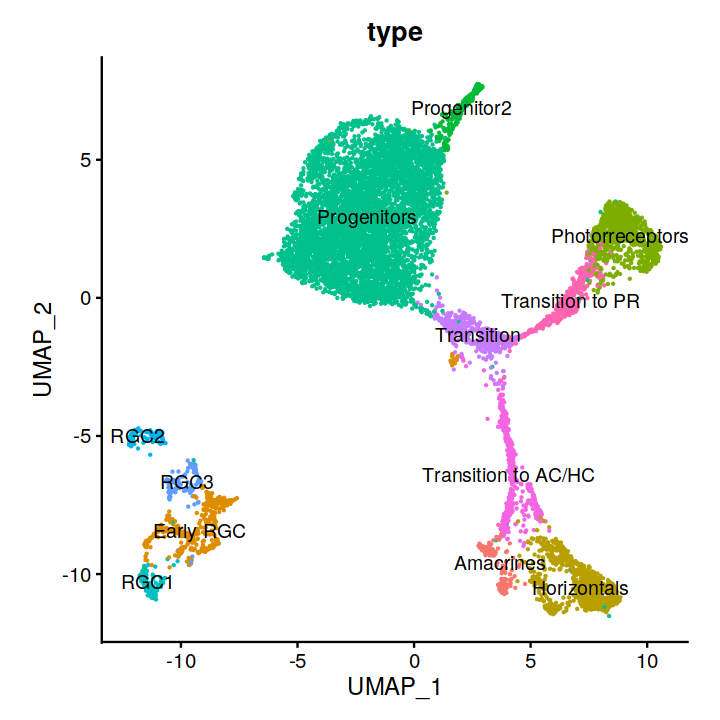

In [65]:
p.umpa.label.cpeak+theme(aspect.ratio = 1) 

In [66]:
ggsave(paste0('plot/fw13p.cpeak.umpa.label.pdf'),height = 6,width = 6)